### Desafío Data Science - Juliana Plácido

#### Notebook III
Baseline Model

In [1]:
#Importamos librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupShuffleSplit


import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importamos el df
#url = 'https://raw.githubusercontent.com/julianaplacido/challenge_ds_placido/develop/df_modelado.csv'
#df = pd.read_csv(url)
df = pd.read_csv('df_modelado.csv')


In [3]:
X = df.drop(['vlo-i','fecha-i', 'atraso_15', 'flag_adelantado'], axis=1)
y = df['atraso_15']

In [4]:
from sklearn.model_selection import train_test_split
trainSize = 0.7

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,
                                  train_size=trainSize)

In [5]:
print('Shape X:', X_train.shape)
print('Shape y:', y_train.shape)

Shape X: (47716, 15)
Shape y: (47716,)


In [6]:
print('Shape X:', X_test.shape)
print('Shape y:', y_test.shape)

Shape X: (20450, 15)
Shape y: (20450,)


Lo primero que vamos a hacer es una Regresión Logística como modelo benchmark para tener una referencia inicial. 
Así mismo, iremos probando diversos modelos hasta llegar a los que más nos interesan: lgbm y XGBoost. 
Como métricas, utilizaremos:

-Curva ROC: Es una representación gráfica de la sensibilidad frente a la especificidad para un sistema clasificador binario. Es decir, es la representación de la proporción de Verdaderos Positivos (VPR) frente a la proporción de Falsos Positivos (FPR) también según se varía el umbral de discriminación. En resumen, la curva roc nos da una idea de que tan bueno es el modelo distinguiendo las clases

In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

#Predict
y_train_pred = model.predict_proba(X_train)[:,1]
y_test_pred = model.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, y_train_pred) ,4) 
test_roc = round(roc_auc_score(y_test, y_test_pred) ,4)

print("Logistic Reg Baseline Train: " + str(train_roc))
print("Logistic Reg Baseline Test: " + str(test_roc))

Logistic Reg Baseline Train: 0.6205
Logistic Reg Baseline Test: 0.6184


In [8]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
#Predict
y_train_pred = tree.predict_proba(X_train)[:,1]
y_test_pred = tree.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, y_train_pred) ,4) 
test_roc = round(roc_auc_score(y_test, y_test_pred) ,4)

print("Tree Classifier Baseline Train: " + str(train_roc))
print("Tree Classifier Baseline Test: " + str(test_roc))

Tree Classifier Baseline Train: 0.9891
Tree Classifier Baseline Test: 0.5942


In [9]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
trees = RandomForestClassifier(random_state=42)
trees.fit(X_train, y_train)
#Predict
y_train_pred = trees.predict_proba(X_train)[:,1]
y_test_pred = trees.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, y_train_pred) ,4) 
test_roc = round(roc_auc_score(y_test, y_test_pred) ,4)

print("Random Forest Classifier Baseline Train: " + str(train_roc))
print("Random Forest Classifier Test: " + str(test_roc))

Random Forest Classifier Baseline Train: 0.9881
Random Forest Classifier Test: 0.6746


#### Probamos algoritmos más complejos

In [13]:
%%time
model_lgbm = LGBMClassifier(random_state=42)
model_lgbm.fit(X_train, y_train)

preds_lgbm_train = model_lgbm.predict_proba(X_train)[:,1]
preds_lgbm_test = model_lgbm.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y, preds_lgbm_train) ,4) 
test_roc = round(roc_auc_score(y_test, preds_lgbm_test) ,4)


print("ROC LGBM Baseline Train: " + str(train_roc))
print("ROC LGBM Baseline Test: " + str(test_roc))

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

In [23]:
feature_imp = pd.DataFrame()
feature_imp['Variable'] = X.columns
feature_imp['importance'] = model_lgbm.feature_importances_
feature_imp['import_percent'] = feature_imp.importance / feature_imp.importance.sum()
feature_imp = feature_imp.sort_values(by='import_percent', ascending=False)
feature_imp.head(12)

,Variable,importance,import_percent
0,dia,744,0.248000
1,mes,573,0.191000
13,cod_destino,505,0.168333
14,cod_aerolinea,438,0.146000
5,periodo_dia,240,0.080000
3,estacion,67,0.022333
2,temporada_alta,63,0.021000
6,Domingo,56,0.018667
8,Lunes,54,0.018000
4,tipo_vuelo,53,0.017667


<Figure size 1080x864 with 0 Axes>

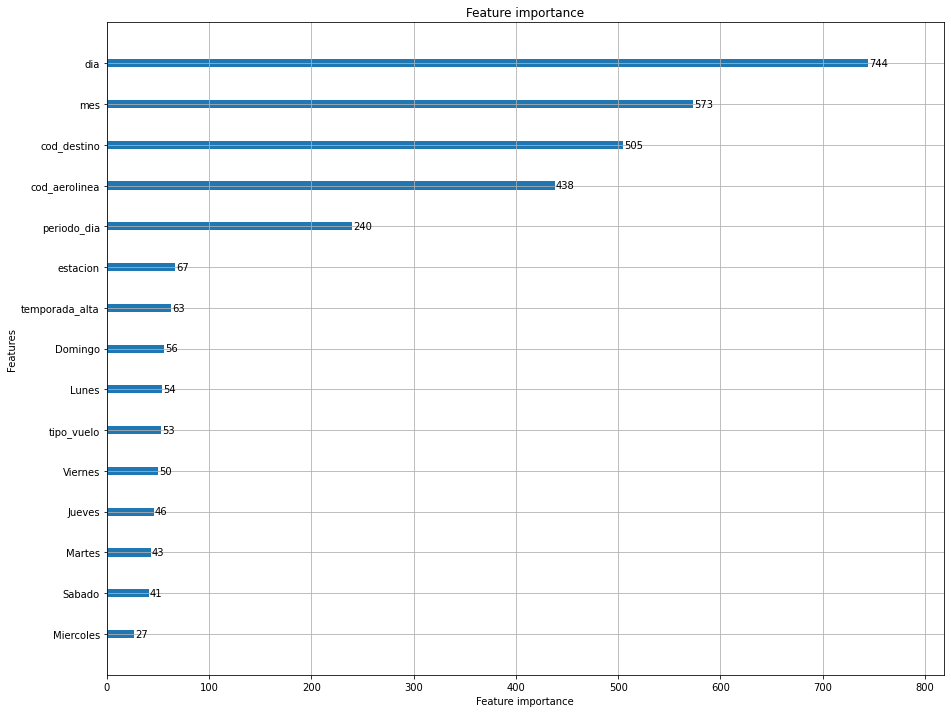

In [24]:
plt.figure(figsize=(15,12))
lgb.plot_importance(model_lgbm,
                    max_num_features=40,
                    importance_type='split',
                    figsize=(15,12))
plt.show()

In [15]:
%%time
model_xgboost = XGBClassifier(random_state=42)
model_xgboost.fit(X_train, y_train)

preds_xgb_train = model_xgboost.predict_proba(X_train)[:,1]
preds_xgb_test = model_xgboost.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, preds_xgb_train) ,4) 
test_roc = round(roc_auc_score(y_test, preds_xgb_test) ,4)

print("ROC XGBoost Baseline Train: " + str(train_roc))
print("ROC XGBoost Baseline Test: " + str(test_roc))

ROC XGBoost Baseline Train: 0.8273
ROC XGBoost Baseline Test: 0.7321
CPU times: user 48.3 s, sys: 298 ms, total: 48.6 s
Wall time: 1.29 s


In [12]:
feat_imp_xgb = pd.DataFrame()
feat_imp_xgb['Variable'] = X_train.columns
feat_imp_xgb['importance'] = model_xgboost.feature_importances_
feat_imp_xgb = feat_imp_xgb.sort_values(by='importance', ascending=False)
feat_imp_xgb.head(12)

,Variable,importance
4,tipo_vuelo,0.256244
5,periodo_dia,0.073749
14,cod_aerolinea,0.070424
1,mes,0.068983
8,Lunes,0.063576
13,cod_destino,0.060215
12,Viernes,0.054289
9,Martes,0.050937
0,dia,0.047280
7,Jueves,0.047220


Vemos que los algoritmos más complejos como XGBoost y LGBM performan mucho mejor que los primeros que probamos. Prosiguiendo con esta línea, vamos a optimizar los hiperparámetros y elegir como algortimo definitivo uno de ellos.